# Импорт необходимых модулей

In [169]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import math

# Чтение данных

In [2]:
ratings = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251')

In [3]:
books = pd.read_csv('data/BX-Books.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251')

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Users\Efim_Golovin\AppData\Local\Continuum\anaconda3\lib\site-packages\

In [4]:
users = pd.read_csv('data/BX-Users.csv', sep=';', header=0, error_bad_lines=False, encoding='Windows-1251')

# Знакомство

Ок, загрузили, надо теперь поглядеть, что это вообще за данные.

In [9]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [12]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
User-ID        1149780 non-null int64
ISBN           1149780 non-null object
Book-Rating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [10]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [13]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
ISBN                   271360 non-null object
Book-Title             271360 non-null object
Book-Author            271360 non-null object
Year-Of-Publication    271360 non-null object
Publisher              271358 non-null object
Image-URL-S            271360 non-null object
Image-URL-M            271360 non-null object
Image-URL-L            271357 non-null object
dtypes: object(8)
memory usage: 16.6+ MB


In [11]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
User-ID     278858 non-null int64
Location    278858 non-null object
Age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Итак, у нас есть 271360 книг и 278858 пользователей, по книгам известны их:
- ISBN;
- название;
- автор;
- год выпуска;
- издательство.

По пользователям (не по всем) известно их:
- местоположение;
- возраст.

Надо глянуть какой процент пользователей указали возраст:

In [16]:
100 * len(users[~users.Age.isnull()]) / len(users)

60.28014258152895

Ок, ~60% пользователей не стесняются, чего не скажешь об остальных.

Глянем, как читатели распределены по возрасту:

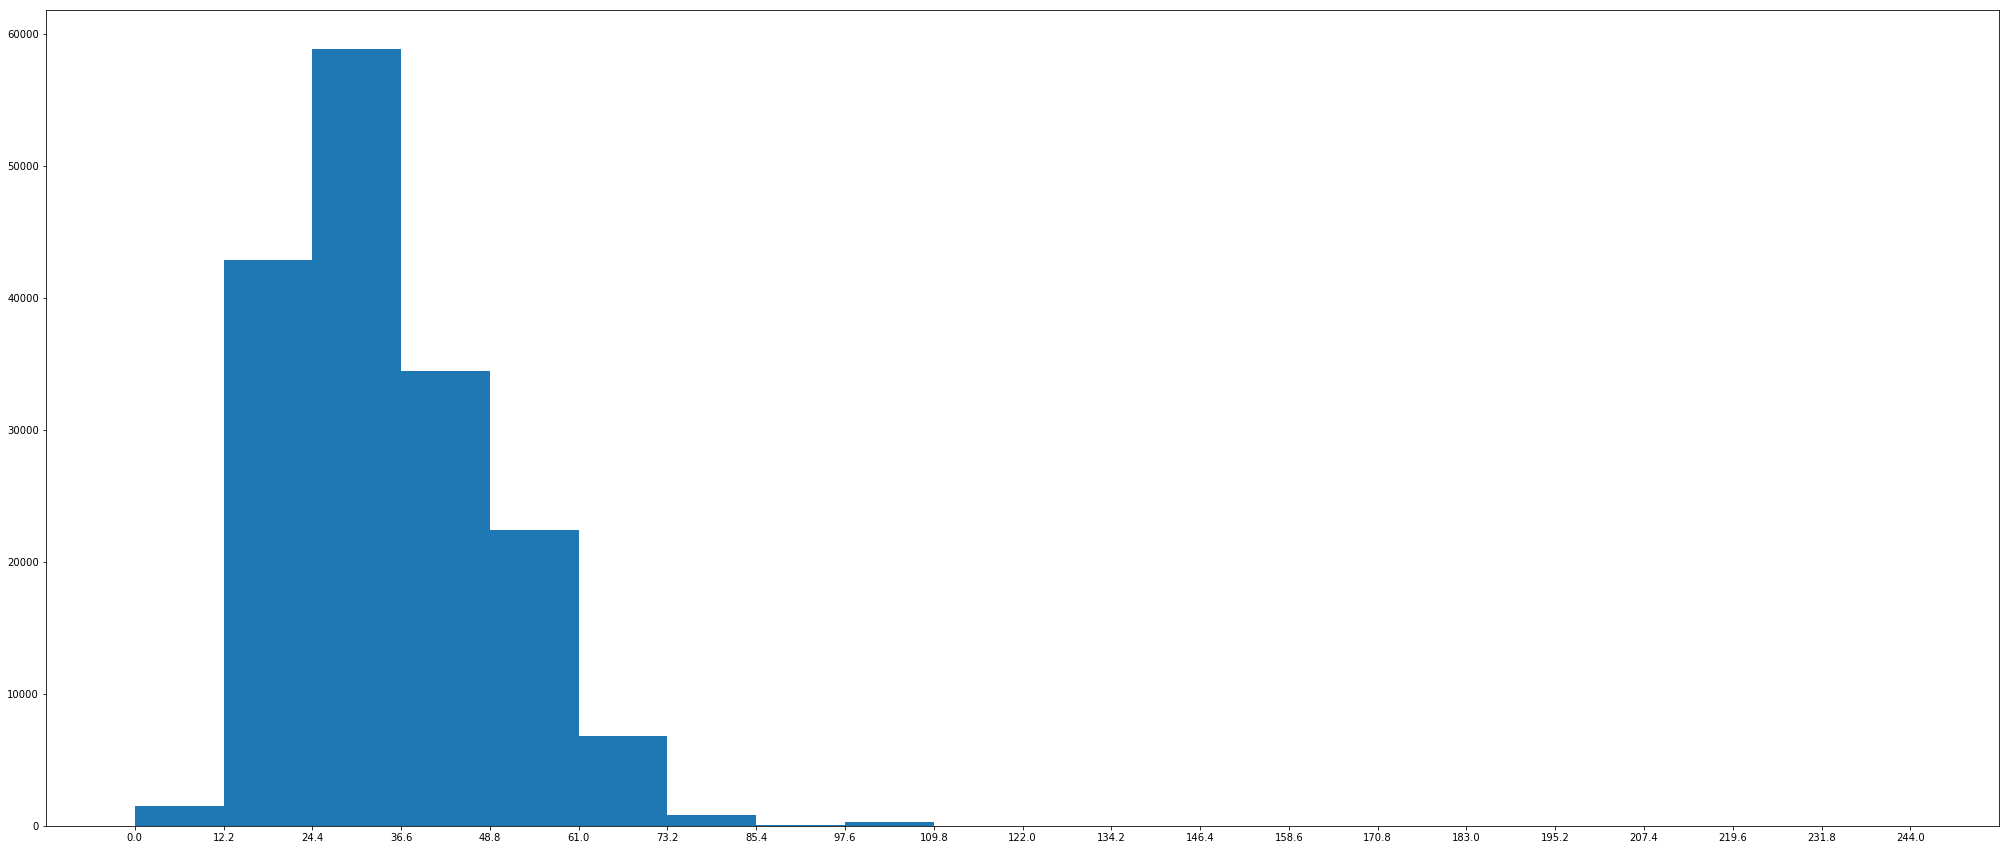

In [178]:
plt.figure(figsize=(35, 15))
n, bins, _ = plt.hist(users[~users.Age.isnull()].Age, bins=20)
plt.xticks(bins)
plt.show()

Заметим, что поле Location состоит из трех пунктов: город, регион, страна.

Надо бы разделить это поле на три, чтобы глянуть, как пользователи по миру раскиданы.

Перед этим надо глянуть, можно ли вообще легко это разделение сделать:

In [91]:
locations = users.Location.values
locations = np.array([loc.split(', ') for loc in locations])

In [108]:
incorrect_items_more = [ind for ind, item in enumerate(locations) if len(item) > 3]
incorrect_items_less = [ind for ind, item in enumerate(locations) if len(item) < 3]

In [145]:
print(100 * (len(incorrect_items_more) + len(incorrect_items_less)) / len(locations))

2.0085491540497316


~2% людей с коряво указанными данными по местоположению.

Надо глянуть, сколько из них оценили какие-нибудь книги:

In [118]:
users_with_their_ratings_l = pd.merge(users[users.index.isin(incorrect_items_less)], ratings, how='inner', on='User-ID')

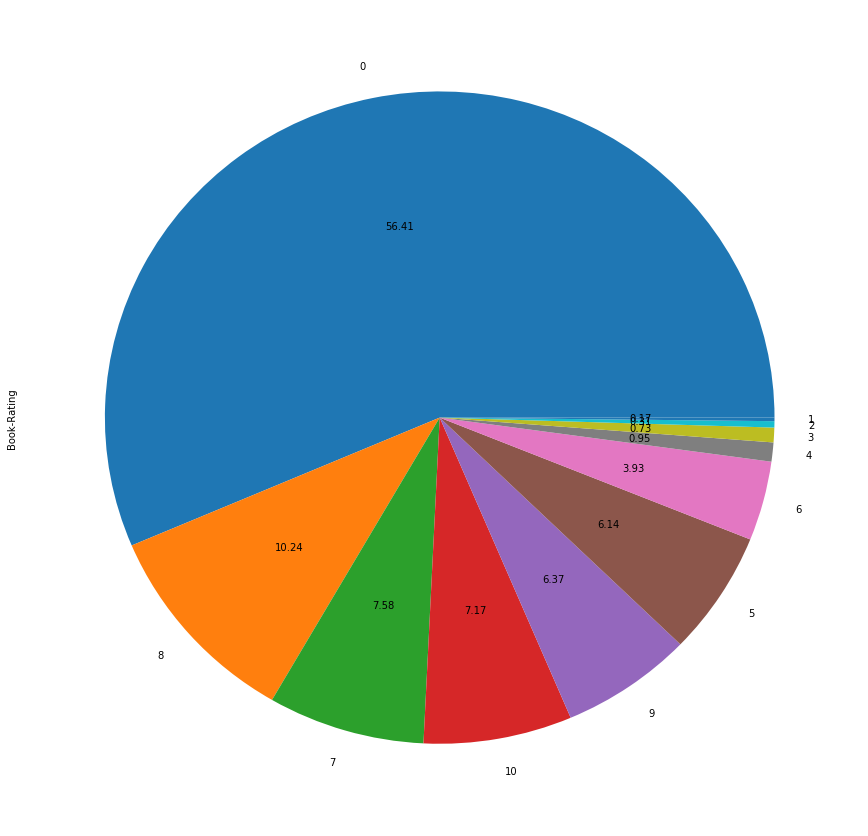

In [143]:
plt.figure(figsize=(15, 15))
users_with_their_ratings_l['Book-Rating'].value_counts().plot.pie(autopct='%.2f')
plt.show()

In [121]:
users_with_their_ratings_m = pd.merge(users[users.index.isin(incorrect_items_more)], ratings, how='inner', on='User-ID')

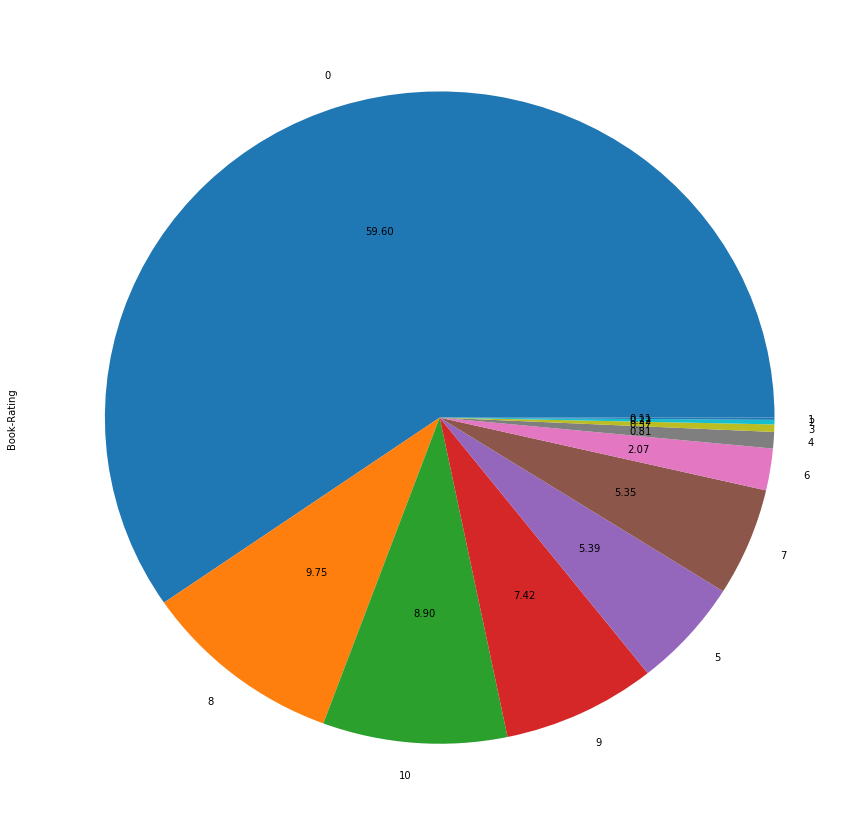

In [142]:
plt.figure(figsize=(15, 15))
users_with_their_ratings_m['Book-Rating'].value_counts().plot.pie(autopct='%.2f')
plt.show()